# Homework 5

# Amol Dattatray Sangar (asangar)

In [35]:
import os
import scipy.io
import numpy as np
import pandas as pd
import librosa as lb
from IPython.display import Audio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

## P1: Kernel PCA [5 points]

In [2]:
concentric = scipy.io.loadmat(os.path.join('data', 'concentric.mat'))
concentric = concentric['X']

In [3]:
concentric.shape

(2, 152)

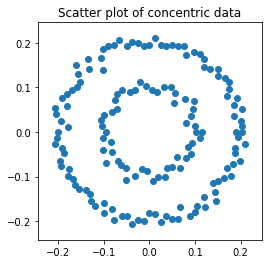

In [4]:
plt.figure(figsize= (4,4))
plt.title('Scatter plot of concentric data')
plt.scatter(concentric[0,:], concentric[1,:],)
plt.show()

In [5]:
# Calculating 's', 'u' and the contribution of one eigen vector
def calc_su(X, w):
    s1 = np.sqrt(np.sum(np.dot(w.T,X)**2))
    u1 = np.dot(X.T, w)/s1
    contrib = s1 * np.dot(w, u1.T)
    return s1, u1, contrib

def eigen_decomposition(X, num_of_eigenvectors, max_iterations):
    i = 0
    eigen_value = []
    eigen_vector = []
    
    for i in range(num_of_eigenvectors):        
        # INITIALIZING w RANDOMLY
        w = np.random.rand(X.shape[0], 1)
        
        # NORMALIZING w
        denom = 0
        for i in range(num_of_eigenvectors):
            denom += w[i]**2
        w = w / np.sqrt(denom)
        
        for epoch in range(max_iterations):
            w = np.dot(X, w)
            w = w / np.sqrt(np.sum(w**2))    # L-2 NORMALIZATION
        
        s1, u1, contrib = calc_su(X, w)        
        
        # Removing the contribution of the eigen vector from the original matrix
        X = X - contrib
        
        eigen_value.append(s1)
        eigen_vector.append(w.reshape(-1,))

    eigen_vector = np.array(eigen_vector)

    return eigen_value, eigen_vector

#### RBF Kernel

In [6]:
def rbf_kernel(i,j):
    return np.exp( -np.sum((i - j)**2) / 0.01 )

In [7]:
kernel = []
for i in range(concentric.shape[1]):
    temp = []
    for j in range(concentric.shape[1]):
        temp.append(rbf_kernel(concentric[:,j], concentric[:,i]))
    
    kernel.append(temp)

kernel = np.array(kernel)

In [8]:
eig_val, eig_vec = eigen_decomposition(kernel, 3, max_iterations=2000)

In [9]:
X = np.concatenate((eig_vec, np.ones(eig_vec.shape[1]).reshape(1,-1)), axis=0)

Y = []
for i in range(152):
    if(i > 50):
        Y.append(1)
    else:
        Y.append(0)
Y = np.array(Y)

In [10]:
X.shape

(4, 152)

#### 3D transformed data

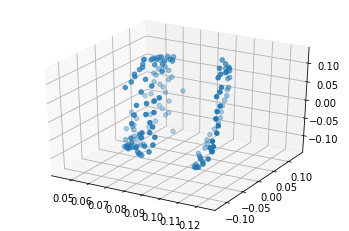

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[0,:], X[1,:], X[2,:], c = None)
plt.show()

#### Activation function

In [12]:
def logistic_activation(x):
    return 1/(1 + np.exp(-x))

In [13]:
def back_propagation(X,max_iterations):
    W = np.random.uniform(0, 1, size=4).reshape(-1, 1)
    error_plot = []
    i = 0
    alpha = 0.2
    for i in range(0,max_iterations,1):
        prediction = logistic_activation(np.dot(W.T, X))
        error = 0.5 * (np.dot((Y - prediction),(Y - prediction).T))**2
        error_plot.append(error)

        delta_W = np.dot(X,((prediction - Y) * prediction * (1 - prediction)).T)
        W = W - alpha * delta_W
    return W,error,error_plot

In [14]:
max_iterations = 100000
W, error, error_plot = back_propagation(X,max_iterations)

In [15]:
Y_hat = logistic_activation(np.dot(W.T, X))
error = 0.5 * (np.dot((Y-Y_hat),(Y-Y_hat).T))**2

In [16]:
print('Perceptron weights: ' + str(W.flatten()))
print('Error: ' + str( round(error[0][0]*100,3)) )
print('Accuracy: ' + str( round((1-error[0][0])*100,3) ))

Perceptron weights: [-220.36936721  -28.35049579    8.83995745   19.64386447]
Error: 1.8
Accuracy: 98.2


#### Error Plot

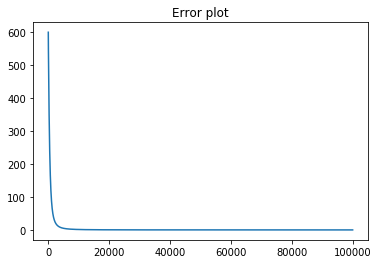

In [17]:
plt.title('Error plot')
plt.plot(np.array(error_plot).reshape(max_iterations,1))
plt.show()

## P2: Neural Networks [5 points]

In [18]:
concentric = scipy.io.loadmat(os.path.join('data', 'concentric.mat'))
concentric = concentric['X']
concentric = concentric/np.sum(concentric, axis = 1).reshape(-1,1)

In [19]:
X = np.concatenate((concentric, np.ones([1,concentric.shape[1]])))

Y = []
for i in range(152):
    if(i > 50):
        Y.append(1)
    else:
        Y.append(0)
Y = np.array(Y)

In [20]:
def neural_net(X, Y, max_iterations, learning_rate):
    np.random.seed(42)
    W1 = np.random.uniform(0, 1, size=9).reshape(3,3)    # 3x3
    W2 = np.random.uniform(0, 1, size=4).reshape(1,4)    # 1x4
    alpha = learning_rate    
    error_plot = []
    
    for i in range(0,max_iterations,1):
        layer1_output = logistic_activation(np.dot(W1, X))
        layer1_output = np.concatenate((layer1_output, np.ones([1, layer1_output.shape[1]])))
        
        pred = logistic_activation(np.dot(W2, layer1_output))
        
        err_output = (pred - Y) * (pred * (1 - pred))
        delta_output = np.dot(err_output, layer1_output.T)
        W2 = W2 - alpha * delta_output
        
        err_l1 = np.dot(W2.T, err_output) * (layer1_output * (1 - layer1_output))
        delta_l1 = np.dot(err_l1, X.T)[:3,:]
        
        W1 = W1 - alpha * delta_l1
        
        error_plot.append(0.5 * np.dot((pred - Y), (pred - Y).T))
        
    return W1, W2, np.array(error_plot).reshape(max_iterations, 1)

In [21]:
W1, W2, error_plot_NN = neural_net(X, Y, 10000, 0.1)

In [22]:
print('Weights W1:\n' + str(W1))
print('\nWeights W2:\n' + str(W2))

Weights W1:
[[-0.10377514  5.40700183  3.73287931]
 [ 7.49383997  2.27749098 -3.64265025]
 [-7.26063264  2.68957171 -3.41679298]]

Weights W2:
[[-19.16135563  19.38407924  19.47123667   5.0051562 ]]


#### Error Plot

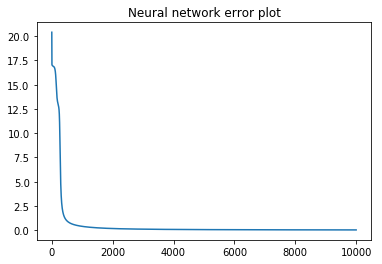

In [23]:
plt.title('Neural network error plot')
plt.plot(error_plot_NN)
plt.show()

## P3: Spoken MNIST [5 points]

In [24]:
# !pip install hmmlearn-0.2.7-cp37-cp37m-win_amd64.whl

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy import signal
import soundfile as sf
import scipy.io as sio
import pandas as pd
import math
from scipy.io import wavfile
from hmmlearn import hmm
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

In [26]:
def get_data(recordings_dir,fileList):
    dataset = {}
    for fileName in fileList:
        label = fileName.split('.')[0].split('_')[0]
        y,sr = lb.load(recordings_dir + fileName,sr=None)
        mfcc_feature = lb.feature.mfcc(y=y,sr=sr)
        if label not in dataset.keys():
            dataset[label] = []
            dataset[label].append(mfcc_feature)
        else:
            exist_feature = dataset[label]
            exist_feature.append(mfcc_feature)
            dataset[label] = exist_feature
    return dataset

def train_test_split():
    train_data_files = []
    test_data_files = []
    recordings_dir = "recordings/"
    fileList = [f for f in os.listdir(recordings_dir) if '_jackson_' in os.path.splitext(f)[0]]
    
    for f in fileList:
        fnew = f.split('_')
        if(int(fnew[2].split('.wav')[0])<45):
            train_data_files.append(f)
        else:
            test_data_files.append(f)
        
    print("Train-Test Split Ratio: 90:10")
    print(f"Train-Test Split Length: {len(train_data_files)}:{len(test_data_files)}")
    
    train_dataset = get_data(recordings_dir,train_data_files)
    test_dataset = get_data(recordings_dir,test_data_files)
    
    return train_dataset,test_dataset

In [27]:
train_dataset, test_dataset = train_test_split()

Train-Test Split Ratio: 90:10
Train-Test Split Length: 450:50


In [28]:
print(len(train_dataset))
print(train_dataset.keys())
print(len(test_dataset))
print(test_dataset.keys())

10
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
10
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


In [29]:
def HMM(data):
    GMMHMM_models = []
    for i in range(len(data)):
        model = hmm.GMMHMM(n_components=2, covariance_type='full', n_iter=200, tol=0.000001)        
        Data = data[str(i)]
        model.fit(np.hstack(Data).T) 
        GMMHMM_models.append(model)
        
    return GMMHMM_models

In [30]:
models = HMM(train_dataset)

In [31]:
label_list = []
predict_list = []
score_dict = {}
scores_table = []
for test_label in test_dataset.keys():
    test_feature = test_dataset[str(test_label)]
    
    digit_score = []
    for model_label in range(len(models)):
        model = models[model_label]
        score = model.score(np.hstack(test_feature).T)
        score_dict[model_label] = score
        digit_score.append(score)
    
    scores_table.append(digit_score)
    predict = max(score_dict, key=score_dict.get)
    
    predict_list.append(str(predict))
    label_list.append(str(test_label))
    
    print(f"True label: {test_label} | Predicted label: {predict}")
    # print(f"Scores received for {test_label} feature:\n {json.dumps(score_dict, indent=4, sort_keys=True)} \n")

True label: 0 | Predicted label: 0
True label: 1 | Predicted label: 1
True label: 2 | Predicted label: 2
True label: 3 | Predicted label: 3
True label: 4 | Predicted label: 4
True label: 5 | Predicted label: 5
True label: 6 | Predicted label: 6
True label: 7 | Predicted label: 7
True label: 8 | Predicted label: 8
True label: 9 | Predicted label: 9


In [32]:
print("Log-likelihood values table")
psc = pd.DataFrame(scores_table, columns=['0','1','2','3','4','5','6','7','8','9'])
display(psc)

Log-likelihood values table


,0,1,2,3,4,5,6,7,8,9
0,-4549.203963,-7563.677429,-7448.109527,-8505.188081,-9155.105512,-9973.961451,-10257.179411,-11367.114281,-8949.261754,-8526.892520
1,-6036.452603,-3422.584395,-5609.345238,-6494.745826,-6816.032655,-6508.768298,-9067.244023,-6904.887166,-7449.815055,-4888.355015
2,-5333.598981,-6601.382594,-3287.222263,-5085.660629,-7847.805014,-8412.137061,-7800.795204,-8645.276584,-5831.057922,-7484.801867
3,-4768.484265,-6578.709272,-4515.246416,-3021.903374,-7265.866664,-8874.620700,-8113.584255,-7929.708332,-5708.716639,-6492.248879
4,-4204.938208,-4383.008143,-5128.878590,-6029.514054,-2726.721212,-6043.805144,-8437.958227,-8041.321396,-7149.012554,-7196.604853
5,-5446.242494,-5250.896835,-5855.862025,-7075.249793,-5458.578349,-3101.775609,-7793.829862,-4744.744488,-6303.129857,-4837.318235
6,-7096.868255,-7683.115406,-6922.349381,-9553.486040,-9609.127357,-6861.818713,-3956.342352,-6527.548639,-6032.932591,-8085.125090
7,-4937.503456,-4800.844161,-5629.136946,-6989.869932,-5101.284842,-4096.695724,-4972.044387,-2707.728530,-5879.103066,-4055.541474
8,-4263.439900,-5003.911351,-4299.171686,-4278.577093,-7002.361126,-7653.963790,-6382.770958,-5943.599301,-2557.794007,-4873.293288
9,-5656.512076,-5025.637260,-5741.532410,-7551.630447,-6885.645482,-6416.286606,-9067.383132,-5748.707321,-6707.255172,-3688.254806


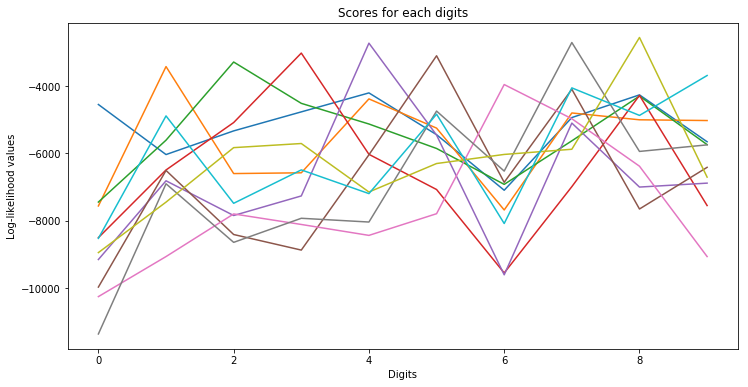

In [33]:
fig = plt.figure(figsize=(12,6))
plt.plot(psc)
plt.title("Scores for each digits")
plt.xlabel("Digits")
plt.ylabel("Log-likelihood values")
plt.show()

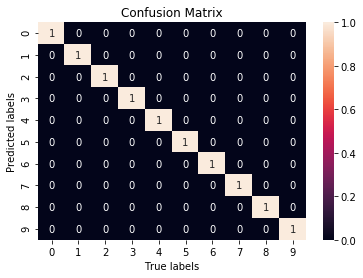

In [34]:
cm = confusion_matrix(label_list,predict_list)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('True labels'); 
ax.set_ylabel('Predicted labels');
ax.set_title('Confusion Matrix'); 